In [1]:
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
import random
from collections import defaultdict

In [2]:
# Create a Simple Graph
def create_simple_graph():
    """Create a simple graph thats easy to understand"""
    G = nx.Graph()
    
    # Add edges to create a small network
    edges = [
        ("A", "B"), ("A", "C"), ("A", "D"), ("A", "E"),
        ("B", "C"), ("B", "E"),
        ("C", "D"), ("C", "F"),
        ("D", "F"), ("D", "G"),
        ("E", "F"), ("E", "H"),
        ("F", "G"), ("F", "H"),
        ("G", "H"), ("G", "A"),
        ("H", "C"), ("H", "D"), ("H", "B"),
        ("I", "A"), ("I", "F"), ("I", "D"),
        ("J", "E"), ("J", "G"),
        ("K", "B"), ("K", "C"), ("K", "H")
    ]
    G.add_edges_from(edges)
    return G

In [3]:
def visualize_graph(G, title = "Graph Structure"):
    """Visualize the graph"""
    plt.figure(figsize = (8, 6))
    pos = nx.spring_layout(G, seed = 42)
    nx.draw(G, pos, with_labels = True, node_color = "lightblue", node_size = 1000, font_size = 16, font_weight = "bold")
    plt.title(title)
    plt.show()

In [4]:
# Node2Vec Biased Random Walks
def calculate_transition_probabilities(graph, current_node, previous_node, p, q):
    """
    Calculate transition probabilities for Node2Vec biased walks
    
    p: Return Parameter (probability of returning to previous node)
        - High p = less likely to return = more exploration
        - Low p = more likely to return = stay local
        
    q: In-Out Parameter (probability of moving to unexplored areas)
        - High q = prefer to stay near current neighborhood (BFS-Like)
        - Low q = prefer to explore far areas (DFS-Like)
    """
    
    neighbors = list(graph.neighbors(current_node))
    probabilites = {}
    
    for neighbor in neighbors:
        if neighbor == previous_node:
            # Going back to where we came from
            probabilites[neighbor] = 1.0 / p
        elif graph.has_edge(neighbor, previous_node):
            # Neighbor is connected to previous node (staying local)
            probabilites[neighbor] = 1.0
        else:
            # Moving to unexplored area
            probabilites[neighbor] = 1.0 / q
            
    # Normalize probabilities
    total_prob = sum(probabilites.values())
    for neighbor in probabilites:
        probabilites[neighbor] /= total_prob
    
    return probabilites

In [5]:
def node2vec_walk(graph, start_node, walk_length, p, q):
    """
    Generate a single Node2Vec biased random walk
    
    This is the KEY difference from DeepWalk!
    Instead of purely random walks, we use p and q to bias the walk.
    """
    
    walk = [start_node]
    
    if walk_length == 1:
        return walk
    
    
    # First step is random (no previous node)
    neighbors = list(graph.neighbors(start_node))
    if not neighbors:
        return walk
    
    current_node = random.choice(neighbors)
    walk.append(current_node)
    previous_node = start_node
    
    # Subsequent steps use biased probabilities
    for step in range(walk_length - 2):
        probabilites = calculate_transition_probabilities(
            graph, current_node, previous_node, p, q
        )
        
        if not probabilites:
            break
        
        # Choose next node based on calculated probabilities
        neighbors = list(probabilites.keys())
        probs = list(probabilites.values())
        
        next_node = np.random.choice(neighbors, p = probs)
        walk.append(next_node)
        
        # Update for next iteration
        previous_node = current_node
        current_node = next_node
        
    return walk

In [6]:
def generate_node2vec_walks(graph, num_walks_per_node, walk_length, p, q):
    """
    Generate many Node2Vec walks from each node
    """
    
    all_walks = []
    nodes = list(graph.nodes())
    
    print(f"Generating Node2Vec walks with p = {p}, q = {q}")
    print(f" - p controls return probability (higher p = less returning)")
    print(f" - q controls exploration (higher q = more local, lower q = more distant)")
    print(f"Generating {num_walks_per_node} walks of length {walk_length} from each node...")
    
    
    for node in nodes:
        for walk_num in range(num_walks_per_node):
            walk = node2vec_walk(graph, node, walk_length, p, q)
            all_walks.append(walk)
            
    print(f"Total walks generated: {len(all_walks)}")
    return all_walks

In [7]:
def show_sample_walks(walks, num_samples = 8):
    """Show some exampke walks"""
    print(f"\nSample Node2Vec Walks:")
    for i in range(min(num_samples, len(walks))):
        walk_str = " -> ".join(walks[i])
        print(f"Walk {i + 1}: {walk_str}")

In [8]:
def compare_walk_strategies(graph, start_node = "A"):
    """
    Compare different p, q combinations to see how they affect walks
    """
    walk_length = 6
    
    print(f"\nComparing walk strategies starting from node '{start_node}':")
    print("-" * 60)
    
    # Different Strategies
    strategies = [
        (0.5, 0.5, "Balanced"),
        (4.0, 1.0, "Return-focused (high p)"),
        (1.0, 0.5, "Exploration-focused (low q)"),
        (1.0, 4.0, "Local-focused (high q)")
    ]
    
    for p, q, description in strategies:
        walks = [node2vec_walk(graph, start_node, walk_length, p, q) for _ in range(3)]
        print(f"\n{description} (p = {p}, q = {q}):")
        for i, walk in enumerate(walks):
            walk_str = "->".join(walk)
            print(f"   Walk {i + 1}: {walk_str}")

In [9]:
# Create Training Data

def create_training_pairs(walks, window_size):
    """
    Create training pairs from walks.
    For each node in a walk, its "context" is the nearby nodes in the same walk
    """
    
    pairs = []
    
    print(f"\nCreating training pairs with window size {window_size}...")
    
    for walk in walks:
        for i, center_node in enumerate(walk):
            # Look at nodes within window_size steps
            start_idx = max(0, i - window_size)
            end_idx = min(len(walk), i + window_size + 1)
            
            for j in range(start_idx, end_idx):
                if i != j:  # Don't pair the node with itself
                    context_node = walk[j]
                    pairs.append((center_node, context_node))
                    
    print(f"Created {len(pairs)} training pairs")
    return pairs

In [10]:
# Training

def initialize_embeddings(nodes, embedding_dim):
    """Create random initial embeddings for each node"""
    embeddings = {}
    
    print(f"\nInitializing {embedding_dim}-dimensional embeddings for {len(nodes)} nodes...")
    
    for node in nodes:
        random_vector = np.random.uniform(-0.5, 0.5, embedding_dim)
        embeddings[node] = random_vector.tolist()
        
    return embeddings

In [11]:
def sigmoid(x):
    """Sigmoid function: converts any number to a probability between 0 and 1"""
    # Clip to prevent overflow
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

In [12]:
def train_simple_skipgram(pairs, embeddings, learning_rate, epochs):
    """
    Simple training loop - this is where the magic happens!
    We want nodes that appear together in walks to have similar embeddings.
    """
    
    print(f"\nTraining for {epochs} epochs with learning rate {learning_rate}...")
    
    for epoch in range(epochs):
        total_loss = 0
        pairs_shuffled = pairs.copy()
        random.shuffle(pairs_shuffled)  # Shuffle for better training
        
        
        for center_node, context_node in pairs_shuffled:
            # Get embeddings for both nodes
            center_emb = np.array(embeddings[center_node])
            context_emb = np.array(embeddings[context_node])
            
            # Calculate how similar they are (dot_product)
            similarity = np.dot(center_emb, context_emb)
            
            # Convert to probability using sigmoid
            prob = sigmoid(similarity)
            
            # We want this probability to be high (close to 1)
            # So we calculate the error
            error = 1 - prob
            
            # Update embeddings to make them more similar
            # This is gradient descent
            gradient = error * learning_rate
            
            # Create new updated embeddings
            new_center_emb = center_emb + gradient * context_emb
            new_context_emb = context_emb + gradient * center_emb
            
            # Store back in dictionary
            embeddings[center_node] = new_center_emb.tolist()
            embeddings[context_node] = new_context_emb.tolist()
            
            total_loss += -np.log(prob + 1e-10)  # Add small value to prevent log(0)
            
        avg_loss = total_loss / len(pairs)
        print(f"Epoch {epoch + 1} / {epochs}, Average Loss: {avg_loss:.4f}")
        
    print("Training Completed!")
    return embeddings

In [13]:
# Analyze and Visualize

def visualize_embeddings(embeddings, title="Node Embeddings"):
    """Visualize the learned embeddings using PCA"""
    nodes = list(embeddings.keys())
    embedding_matrix = np.array([np.array(embeddings[node]) for node in nodes])
    
    # Reduce to 2D using PCA
    if embedding_matrix.shape[1] > 2:
        pca = PCA(n_components=2)
        embedding_2d = pca.fit_transform(embedding_matrix)
    else:
        embedding_2d = embedding_matrix
    
    plt.figure(figsize=(10, 8))
    
    # Plot each node
    for i, node in enumerate(nodes):
        x, y = embedding_2d[i]
        plt.scatter(x, y, s=300, alpha=0.7)
        plt.annotate(str(node), (x, y), ha='center', va='center', 
                    fontsize=12, fontweight='bold')
    
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.grid(True, alpha=0.3)
    plt.show()

In [14]:
def find_similar_nodes(target_node, embeddings, top_k=3):
    """Find nodes with similar embeddings"""
    target_embedding = np.array(embeddings[target_node])
    similarities = {}
    
    for node in embeddings.keys():
        if node != target_node:
            node_embedding = np.array(embeddings[node])
            # Calculate cosine similarity
            dot_product = np.dot(target_embedding, node_embedding)
            norm_target = np.linalg.norm(target_embedding)
            norm_node = np.linalg.norm(node_embedding)
            similarity = dot_product / (norm_target * norm_node + 1e-10)
            similarities[node] = similarity
    
    # Sort by similarity (highest first)
    sorted_nodes = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_nodes[:top_k]

In [15]:
# Compare different Node2Vec strategies

def run_node2vec_with_strategy(graph, p, q, strategy_name):
    """Run Node2Vec with specific p,q parameters"""
    print(f"\n{'='*20} {strategy_name} (p={p}, q={q}) {'='*20}")
    
    # Generate walks
    walks = generate_node2vec_walks(graph, num_walks_per_node=15, walk_length=6, p=p, q=q)
    show_sample_walks(walks, num_samples=4)
    
    # Create training data
    pairs = create_training_pairs(walks, window_size=2)
    
    # Train embeddings
    nodes = list(graph.nodes())
    embeddings = initialize_embeddings(nodes, embedding_dim=8)
    trained_embeddings = train_simple_skipgram(pairs, embeddings, learning_rate=0.1, epochs=30)
    
    # Visualize results
    visualize_embeddings(trained_embeddings, f"Node2Vec Embeddings - {strategy_name}")
    
    # Show similarities
    test_node = 'A'
    similar_nodes = find_similar_nodes(test_node, trained_embeddings)
    print(f"\nNodes most similar to '{test_node}' with {strategy_name}:")
    for node, similarity in similar_nodes:
        print(f"  {node}: {similarity:.3f}")
    
    return trained_embeddings

In [16]:
# Run Node2Vec with different strategies

def run_node2vec_comparison():
    """
    Run Node2Vec with different p,q combinations to see the difference
    """
    print("="*70)
    print("NODE2VEC ALGORITHM - COMPARING DIFFERENT WALK STRATEGIES")
    print("="*70)
    
    # Create and show the graph
    print("\nCreating the graph...")
    G = create_simple_graph()
    print(f"Graph has {G.number_of_nodes()} nodes: {list(G.nodes())}")
    print(f"Graph has {G.number_of_edges()} edges")
    visualize_graph(G)
    
    # Show how different p,q values affect walks
    print("\n" + "="*70)
    print("UNDERSTANDING p AND q PARAMETERS")
    print("="*70)
    print("p = Return parameter:")
    print("  - High p (e.g., 4): Less likely to return to previous node")
    print("  - Low p (e.g., 0.5): More likely to return to previous node")
    print("\nq = In-out parameter:")
    print("  - High q (e.g., 4): Stay in local neighborhood (BFS-like)")
    print("  - Low q (e.g., 0.5): Explore distant nodes (DFS-like)")
    
    compare_walk_strategies(G)
    
    # Run Node2Vec with different strategies
    strategies = [
        (1.0, 1.0, "Balanced (like DeepWalk)"),
        (4.0, 1.0, "Exploration-focused"),
        (1.0, 0.5, "Distance-focused (DFS-like)"),
        (1.0, 4.0, "Local-focused (BFS-like)")
    ]
    
    all_results = {}
    
    for p, q, name in strategies:
        embeddings = run_node2vec_with_strategy(G, p, q, name)
        all_results[name] = embeddings
    
    # Compare all strategies side by side
    compare_all_strategies(all_results)
    
    return G, all_results

In [17]:
def compare_walk_strategies(graph, start_node='A'):
    """
    Show how different p,q values create different walk patterns
    """
    walk_length = 8
    
    print(f"\nExample walks starting from node '{start_node}':")
    print("-" * 60)
    
    strategies = [
        (1.0, 1.0, "Balanced (p=1, q=1)"),
        (4.0, 1.0, "Exploration (p=4, q=1)"),
        (1.0, 0.5, "Distance (p=1, q=0.5)"),
        (1.0, 4.0, "Local (p=1, q=4)")
    ]
    
    for p, q, description in strategies:
        print(f"\n{description}:")
        walks = []
        for _ in range(3):
            walk = node2vec_walk(graph, start_node, walk_length, p, q)
            walks.append(walk)
            walk_str = " -> ".join(walk)
            print(f"  {walk_str}")

In [18]:
def compare_all_strategies(results):
    """Create a side-by-side comparison of all strategies"""
    print(f"\n{'='*70}")
    print("FINAL COMPARISON - NODE SIMILARITIES ACROSS STRATEGIES")
    print("="*70)
    
    test_node = 'A'
    print(f"Most similar nodes to '{test_node}' with different strategies:")
    print("-" * 70)
    
    for strategy_name, embeddings in results.items():
        similar_nodes = find_similar_nodes(test_node, embeddings, top_k=3)
        print(f"\n{strategy_name}:")
        for node, similarity in similar_nodes:
            print(f"  {node}: {similarity:.3f}")

In [19]:
# Simple Node2Vec Function

def simple_node2vec(graph, p=1.0, q=1.0, embedding_dim=16, num_walks=20, walk_length=10):
    """
    Simple one-function Node2Vec implementation
    
    Args:
        graph: NetworkX graph
        p: Return parameter (higher = less likely to return)
        q: In-out parameter (higher = more local exploration)
        embedding_dim: Size of embedding vectors
        num_walks: Number of walks per node
        walk_length: Length of each walk
    """
    print(f"Running Simple Node2Vec with p={p}, q={q}")
    
    # Step 1: Generate walks
    walks = generate_node2vec_walks(graph, num_walks, walk_length, p, q)
    
    # Step 2: Create training pairs
    pairs = create_training_pairs(walks, window_size=3)
    
    # Step 3: Train embeddings
    nodes = list(graph.nodes())
    embeddings = initialize_embeddings(nodes, embedding_dim)
    trained_embeddings = train_simple_skipgram(pairs, embeddings, learning_rate=0.1, epochs=50)
    
    return trained_embeddings

NODE2VEC ALGORITHM - COMPARING DIFFERENT WALK STRATEGIES

Creating the graph...
Graph has 11 nodes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
Graph has 27 edges


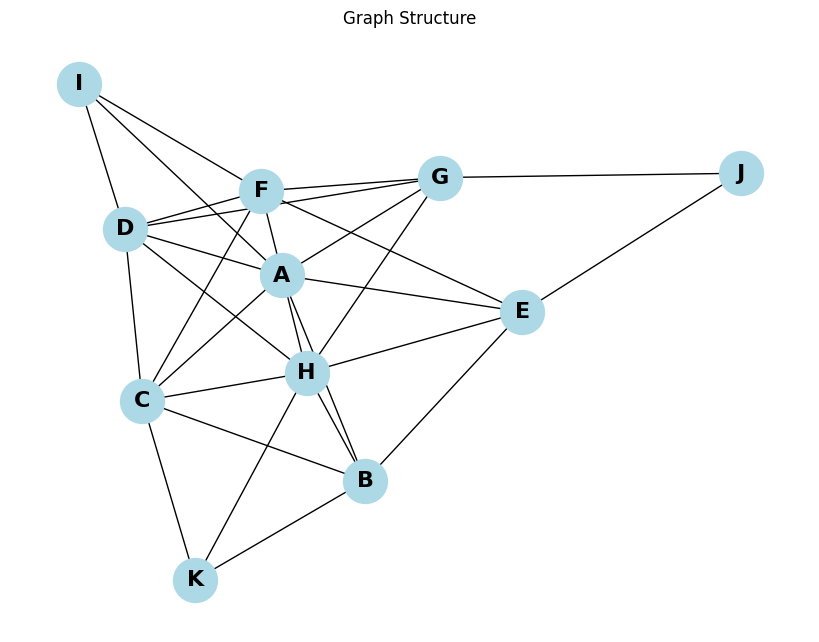


UNDERSTANDING p AND q PARAMETERS
p = Return parameter:
  - High p (e.g., 4): Less likely to return to previous node
  - Low p (e.g., 0.5): More likely to return to previous node

q = In-out parameter:
  - High q (e.g., 4): Stay in local neighborhood (BFS-like)
  - Low q (e.g., 0.5): Explore distant nodes (DFS-like)

Example walks starting from node 'A':
------------------------------------------------------------

Balanced (p=1, q=1):
  A -> I -> F -> I -> D -> G -> D -> A
  A -> B -> A -> I -> F -> H -> E -> J
  A -> B -> K -> B -> A -> C -> B -> E

Exploration (p=4, q=1):
  A -> I -> F -> D -> G -> F -> D -> C
  A -> D -> G -> J -> E -> F -> G -> D
  A -> C -> F -> D -> A -> I -> D -> H

Distance (p=1, q=0.5):
  A -> C -> D -> A -> E -> F -> C -> D
  A -> C -> A -> I -> F -> G -> H -> C
  A -> I -> F -> C -> K -> H -> K -> H

Local (p=1, q=4):
  A -> B -> E -> H -> E -> B -> A -> C
  A -> I -> A -> D -> I -> F -> D -> G
  A -> I -> A -> I -> A -> I -> D -> A

==================== Ba

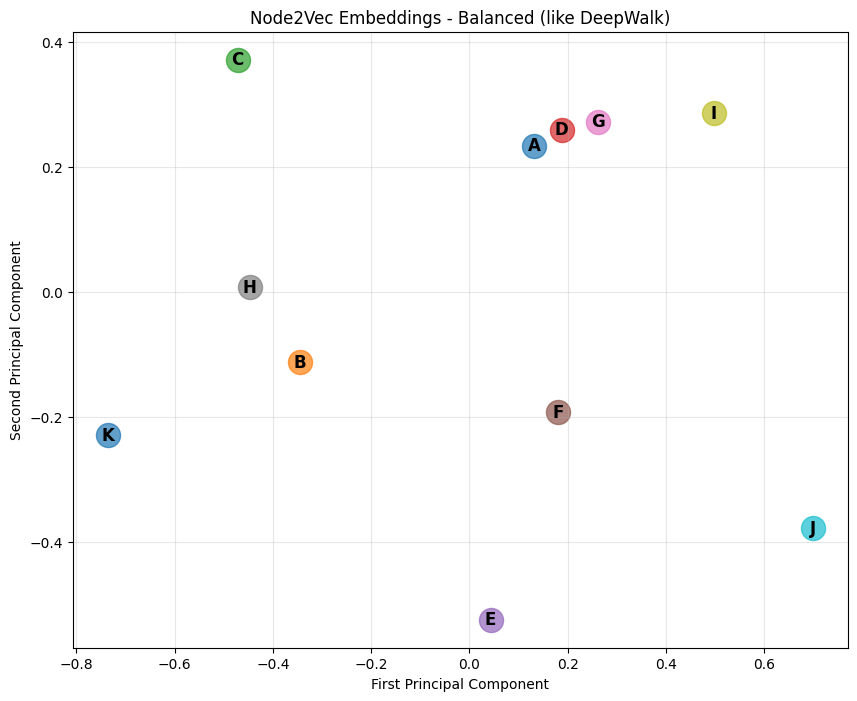


Nodes most similar to 'A' with Balanced (like DeepWalk):
  G: 0.989
  B: 0.981
  D: 0.979

==================== Exploration-focused (p=4.0, q=1.0) ====================
Generating Node2Vec walks with p = 4.0, q = 1.0
 - p controls return probability (higher p = less returning)
 - q controls exploration (higher q = more local, lower q = more distant)
Generating 15 walks of length 6 from each node...
Total walks generated: 165

Sample Node2Vec Walks:
Walk 1: A -> B -> K -> B -> C -> D
Walk 2: A -> C -> F -> I -> A -> C
Walk 3: A -> B -> H -> G -> D -> F
Walk 4: A -> B -> C -> A -> E -> F

Creating training pairs with window size 2...
Created 2970 training pairs

Initializing 8-dimensional embeddings for 11 nodes...

Training for 30 epochs with learning rate 0.1...
Epoch 1 / 30, Average Loss: 0.0603
Epoch 2 / 30, Average Loss: 0.0013
Epoch 3 / 30, Average Loss: 0.0007
Epoch 4 / 30, Average Loss: 0.0004
Epoch 5 / 30, Average Loss: 0.0003
Epoch 6 / 30, Average Loss: 0.0002
Epoch 7 / 30, Ave

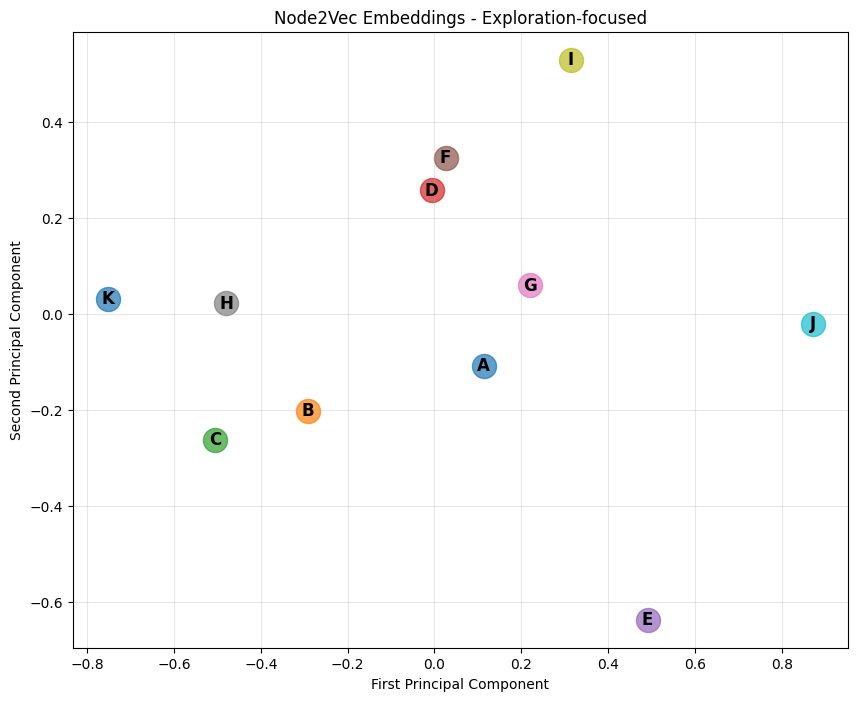


Nodes most similar to 'A' with Exploration-focused:
  B: 0.983
  D: 0.982
  I: 0.978

==================== Distance-focused (DFS-like) (p=1.0, q=0.5) ====================
Generating Node2Vec walks with p = 1.0, q = 0.5
 - p controls return probability (higher p = less returning)
 - q controls exploration (higher q = more local, lower q = more distant)
Generating 15 walks of length 6 from each node...
Total walks generated: 165

Sample Node2Vec Walks:
Walk 1: A -> I -> F -> E -> F -> C
Walk 2: A -> D -> H -> K -> B -> A
Walk 3: A -> C -> A -> G -> H -> D
Walk 4: A -> C -> D -> G -> A -> D

Creating training pairs with window size 2...
Created 2970 training pairs

Initializing 8-dimensional embeddings for 11 nodes...

Training for 30 epochs with learning rate 0.1...
Epoch 1 / 30, Average Loss: 0.0585
Epoch 2 / 30, Average Loss: 0.0013
Epoch 3 / 30, Average Loss: 0.0007
Epoch 4 / 30, Average Loss: 0.0004
Epoch 5 / 30, Average Loss: 0.0003
Epoch 6 / 30, Average Loss: 0.0003
Epoch 7 / 30, 

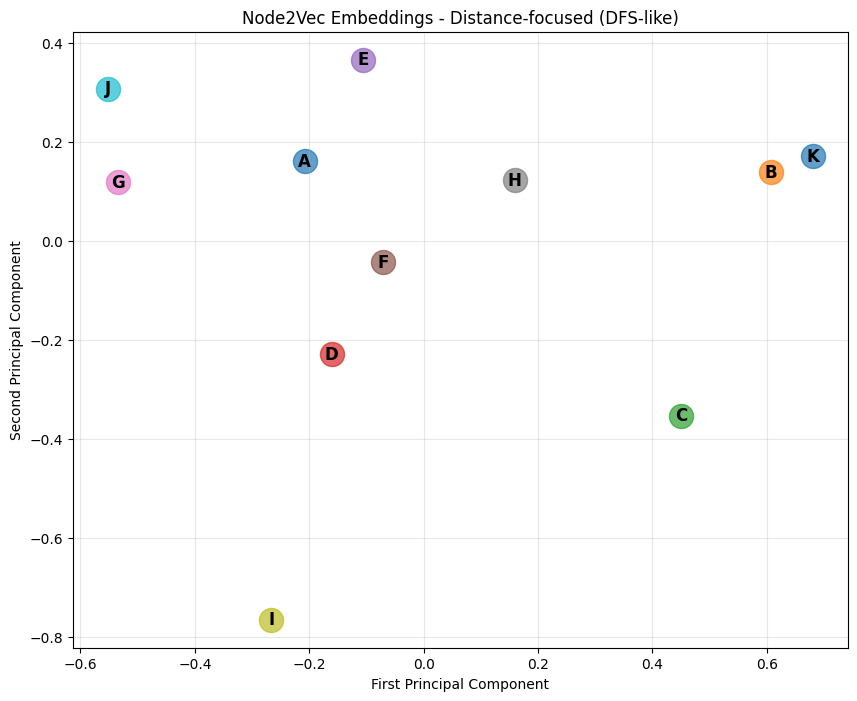


Nodes most similar to 'A' with Distance-focused (DFS-like):
  F: 0.987
  E: 0.983
  J: 0.972

==================== Local-focused (BFS-like) (p=1.0, q=4.0) ====================
Generating Node2Vec walks with p = 1.0, q = 4.0
 - p controls return probability (higher p = less returning)
 - q controls exploration (higher q = more local, lower q = more distant)
Generating 15 walks of length 6 from each node...
Total walks generated: 165

Sample Node2Vec Walks:
Walk 1: A -> C -> B -> C -> B -> C
Walk 2: A -> C -> H -> B -> H -> G
Walk 3: A -> I -> D -> I -> D -> A
Walk 4: A -> D -> G -> D -> C -> A

Creating training pairs with window size 2...
Created 2970 training pairs

Initializing 8-dimensional embeddings for 11 nodes...

Training for 30 epochs with learning rate 0.1...
Epoch 1 / 30, Average Loss: 0.0524
Epoch 2 / 30, Average Loss: 0.0014
Epoch 3 / 30, Average Loss: 0.0007
Epoch 4 / 30, Average Loss: 0.0005
Epoch 5 / 30, Average Loss: 0.0003
Epoch 6 / 30, Average Loss: 0.0003
Epoch 7 /

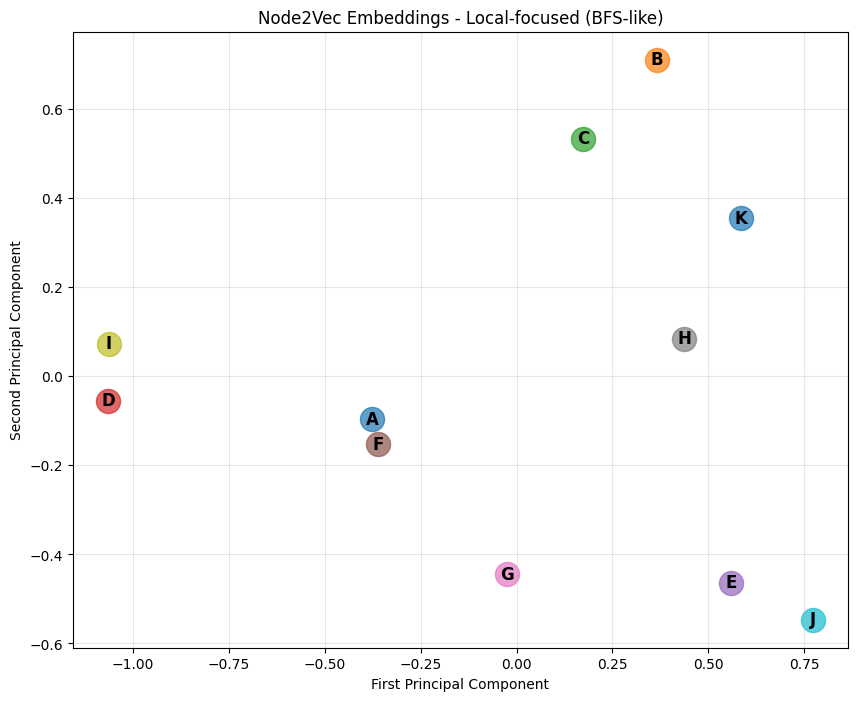


Nodes most similar to 'A' with Local-focused (BFS-like):
  F: 0.968
  D: 0.965
  G: 0.960

FINAL COMPARISON - NODE SIMILARITIES ACROSS STRATEGIES
Most similar nodes to 'A' with different strategies:
----------------------------------------------------------------------

Balanced (like DeepWalk):
  G: 0.989
  B: 0.981
  D: 0.979

Exploration-focused:
  B: 0.983
  D: 0.982
  I: 0.978

Distance-focused (DFS-like):
  F: 0.987
  E: 0.983
  J: 0.972

Local-focused (BFS-like):
  F: 0.968
  D: 0.965
  G: 0.960


In [20]:
random.seed(42)
np.random.seed(42)

graph, results = run_node2vec_comparison()